Loaded .npy file with shape: (900, 256, 256)
3D data detected. Showing 5 evenly spaced slices...


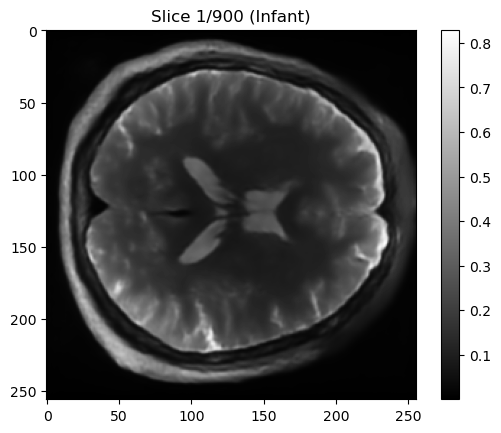

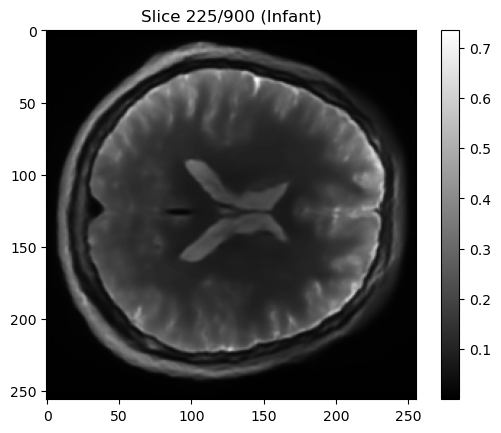

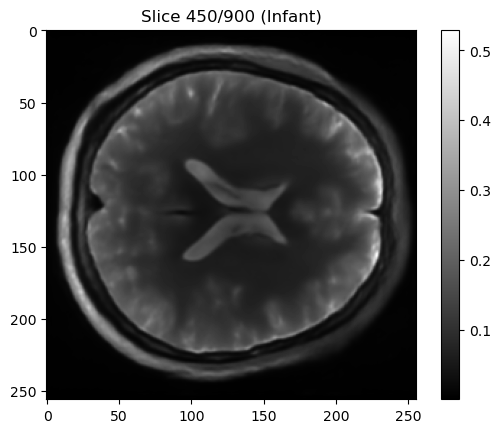

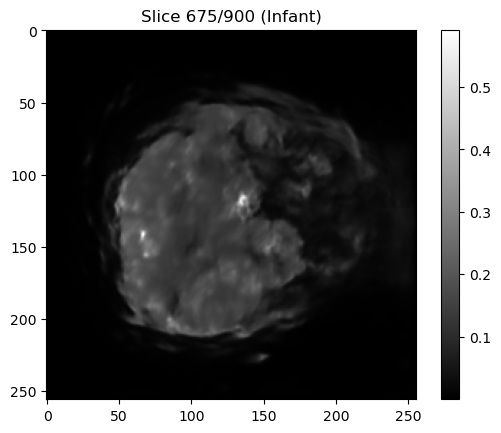

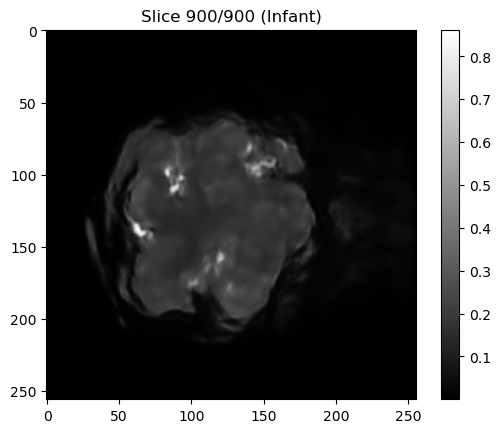

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse

def show_npy(file_path):
    # Load the .npy file
    data = np.load(file_path)
    
    # Check the shape of the data
    print(f"Loaded .npy file with shape: {data.shape}")
    
    # If the data is 2D, display it as an image
    if len(data.shape) == 2:
        plt.imshow(data, cmap='gray')
        plt.colorbar()
        plt.title("2D Data Visualization")
        plt.show()
    # If the data is 3D, display 4 evenly spaced slices
    elif len(data.shape) == 3:
        print("3D data detected. Showing 5 evenly spaced slices...")
        num_slices = data.shape[0]
        indices = np.linspace(0, num_slices - 1, 5, dtype=int)  # Select 4 evenly spaced slices
        for i, idx in enumerate(indices):
            plt.imshow(data[idx], cmap='gray')
            plt.title(f"Slice {idx+1}/{num_slices} (Infant)")
            plt.colorbar()
            plt.show()
    else:
        print("Data has unsupported dimensions for visualization.")


# file_path = 'pred.npy'
file_path = 'experiment/version_6/test/test_samples/pred.npy' 
show_npy(file_path)

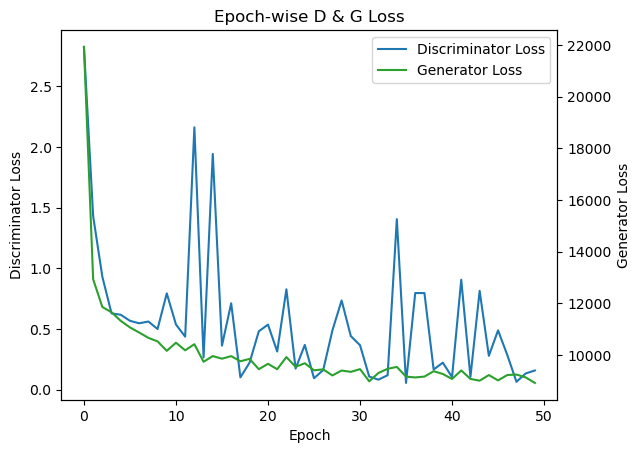

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Read raw CSV — no comment-char, no special skipping:
df = pd.read_csv("experiment/version_6/metrics.csv", comment=',')

# 2. Filter for end‑of‑epoch rows
df_epoch = df.dropna(subset=["epoch", "d_loss_epoch", "g_loss/total_epoch"]).copy()
df_epoch["epoch"] = df_epoch["epoch"].astype(int)


# 3. Extract data
epochs = df_epoch["epoch"]
d_loss = df_epoch["d_loss_epoch"]
g_loss = df_epoch["g_loss/total_epoch"]

# 4. Plot with twin y‑axes
fig, ax1 = plt.subplots()
ax1.plot(epochs, d_loss, label="Discriminator Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Discriminator Loss")
ax2 = ax1.twinx()
ax2.plot(epochs, g_loss, label="Generator Loss", color="tab:green")
ax2.set_ylabel("Generator Loss")

# 5. Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")

plt.title("Epoch‑wise D & G Loss")
plt.show()

In [ ]:
# inspect_models.py
import os
os.environ["TORCH_CUDA_ARCH_LIST"] = "9.0"
import torch
from torchinfo import summary
from torchviz import make_dot

from diffusion import DiffusionBridge
from backbones.ncsnpp import NCSNpp
from backbones.discriminator import Discriminator_large

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # 1) Example init params (tweak these to match your config.yaml!)
    generator_params = {
        "self_recursion": True,
        "z_emb_dim": 256,
        "ch_mult": [1,1,2,2,4,4],
        "num_res_blocks": 2,
        "attn_resolutions": [16],
        "dropout": 0.0,
        "resamp_with_conv": True,
        "image_size": 256,
        "conditional": True,
        "fir": True,
        "fir_kernel": [1,3,3,1],
        "skip_rescale": True,
        "resblock_type": "biggan",
        "progressive": "none",
        "progressive_input": "residual",
        "embedding_type": "positional",
        "combine_method": "sum",
        "fourier_scale": 16,
        "nf": 64,
        "num_channels": 2,
        "nz": 100,
        "n_mlp": 3,
        "centered": True,
        "not_use_tanh": False,
    }
    discriminator_params = {
        "nc": 1,
        "ngf": 32,
        "t_emb_dim": 256,
    }
    diffusion_params = {
        "n_steps": 10,
        "gamma": 1.0,
        "beta_start": 0.1,
        "beta_end": 3.0,
        "n_recursions": 2,
        "consistency_threshold": 0.01,
    }

    # 2) Instantiate
    print("=== Generator (NCSNpp) ===")
    gen = NCSNpp(**generator_params).to(device)
    print(gen, "\n")

    print("=== Discriminator (large) ===")
    disc = Discriminator_large(**discriminator_params).to(device)
    print(disc, "\n")

    print("=== DiffusionBridge ===")
    diff = DiffusionBridge(**diffusion_params).to(device)
    print(diff, "\n")

    # 3) torchinfo summaries
    print("=== torchinfo.summary: Generator ===")
    summary(gen,
            input_data=[torch.randn(1, generator_params["num_channels"] + 1,    #  x_r channel + data channels
                                     generator_params["image_size"],
                                     generator_params["image_size"],
                                     device=device),
                        torch.randint(1, diffusion_params["n_steps"]+1, (1,), device=device)],
            depth=3)

    print("\n=== torchinfo.summary: Discriminator ===")
    summary(disc,
            input_data=[torch.randn(1, discriminator_params["nc"],  # x_{t-1}
                                     generator_params["image_size"],
                                     generator_params["image_size"],
                                     device=device),
                        torch.randn(1, discriminator_params["nc"],  # x_t
                                     generator_params["image_size"],
                                     generator_params["image_size"],
                                     device=device),
                        torch.randint(1, diffusion_params["n_steps"]+1, (1,), device=device)],
            depth=3)

    # 4) (Optional) visualize discriminator graph
    x_tm1 = torch.randn(1, discriminator_params["nc"],
                        generator_params["image_size"],
                        generator_params["image_size"],
                        device=device)
    x_t   = torch.randn_like(x_tm1)
    t     = torch.randint(1, diffusion_params["n_steps"]+1, (1,), device=device)
    out = disc(x_tm1, x_t, t)
    dot = make_dot(out, params=dict(disc.named_parameters()))
    dot.format = "png"
    dot.render("discriminator_graph", cleanup=True)
    print("\nWrote `discriminator_graph.png`")

main()

ModuleNotFoundError: No module named 'diffusion'